In [30]:
import numpy as np
from scipy import optimize as op
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from fp_plotting_funcs import *
from statistics import median

In [31]:
# sn20ano_ztf = read_in_data('../../data/forced_phot_data/20ano_fp_lc.txt', data_source='ztf_fp')

# sn20ano_at = read_in_data('../../data/forced_phot_data/sn20ano_atlas.txt', data_source='atlas')

# multi_band_plot(sn20ano_ztf, _, sn20ano_at, ID='20ano', xlims=[868+2.458e6, 915+2.458e6], ylims=[25,18.5],save=False, ztf=False, atlas=True, asassn=False)
# plt.title('Uncleaned Lightcurves - 20ano')

In [32]:
#cleaning data

In [33]:
def get_mag_from_atlas_fp(filename, snt=3, snu=5):
    """
    Processes the results of an ATLAS FP request into final magnitudes.
    Takes as input the name of a file containing raw ATLAS FP data
    and returns a dictionary of cleaned, final magnitudes
    """

    cols_atlas = ['MJD', 'm', 'dm', 'uJy', 'duJy', 'F', 'err', 'chi/N', 'RA', 'Dec', 'x', 'y', 'maj', 'min', 'phi', 'apfit', 'mag5sig', 'Sky', 'Obs']
    full_df = pd.read_csv(filename, skiprows=1, names=cols_atlas, delim_whitespace=True)
    
    colors = {'c': 'cyan', 'o': 'orange'}
    atlas_data = {}
    for filt in ['c', 'o']:

        df = full_df[(full_df['F'] == filt) & (full_df['chi/N'] < 4.0)].reset_index(drop=True)

        if len(df) == 0:
            continue

        mjdmin = int(df['MJD'].iloc[0]) - 1
        mjdmax = int(df['MJD'].iloc[-1]) - 1
        mjds = np.linspace(mjdmin, mjdmax, int(mjdmax-mjdmin)+1)

        ### Bin dataframe by mjds
        df['bin'] = pd.cut(df['MJD'], mjds, labels=mjds[:-1])

        for mjd in mjds:
            # Get rows that fell into this bin
            good = np.where((df['bin'] == mjd))[0]
            if len(good) == 0:
                continue

            avg_mjd = np.average(df['MJD'][good])
            avg_fluxes = np.average(df['uJy'][good], weights=1/df['duJy'][good].values**2)
            avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df['duJy'][good].values]))

            if avg_fluxes / avg_flux_errs > snt:
                avg_mag = -2.5*np.log10(avg_fluxes) + 23.9
                avg_mag_err = 1.0857 * avg_flux_errs / avg_fluxes

                # plt.errorbar(avg_mjd, avg_mag, yerr=avg_mag_err, fmt='o', color=colors[filt], mec='black')

            else:
                avg_mag = -2.5*np.log10(snu * avg_flux_errs) + 23.9
                avg_mag_err = 9999

                # plt.scatter(avg_mjd, avg_mag, marker='v', color=colors[filt], edgecolor='black', alpha=0.5)

            atlas_data.setdefault(filt, []).append({'mag': avg_mag, 'err': avg_mag_err, 'mjd': avg_mjd})

    # plt.gca().invert_yaxis()
    # plt.show()

    return atlas_data   

In [34]:
def process_ztf_fp(filename, jdstart, jdend):

    """
    Processes the raw ZTF forced photometry from saved file
    and returns a Pandas dataframe of the cleaned data
    """

    full_df = pd.read_csv(filename, delim_whitespace=True, comment='#', header=0, names=['sindex', 'field', 'ccdid', 'qid', 'filter',
                            'pid', 'infobitssci', 'sciinpseeing',
                            'scibckgnd', 'scisigpix', 'zpmaginpsci',
                            'zpmaginpsciunc', 'zpmaginpscirms',
                            'clrcoeff', 'clrcoeffunc', 'ncalmatches',
                            'exptime', 'adpctdif1', 'adpctdif2',
                            'diffmaglim', 'zpdiff', 'programid', 'jd',
                            'rfid', 'forcediffimflux',
                            'forcediffimfluxunc', 'forcediffimsnr',
                            'forcediffimchisq', 'forcediffimfluxap',
                            'forcediffimfluxuncap', 'forcediffimsnrap',
                            'aperturecorr', 'dnearestrefsrc',
                            'nearestrefmag', 'nearestrefmagunc',
                            'nearestrefchi', 'nearestrefsharp',
                            'refjdstart', 'refjdend', 'procstatus'])

    # Get rid of bad data
    df = full_df[(full_df['infobitssci'] < 33554432) & (full_df['scisigpix'] <= 25) & (full_df['sciinpseeing'] <= 4)].reset_index(drop=True)

    # Make baseline correction
    colors = {'ZTF_g': 'green', 'ZTF_r': 'red', 'ZTF_i': 'brown'}
    # plt.figure()

    for filt in ['ZTF_g', 'ZTF_r', 'ZTF_i']:
        ### Get unique values of field, ccdid, qid
        fields = set(df[df['filter'] == filt]['field'].values)
        ccdids = set(df[df['filter'] == filt]['ccdid'].values)
        qids = set(df[df['filter'] == filt]['qid'].values)        
       
        for field in fields:
            for ccdid in ccdids:
                for qid in qids:
                    current_df = df[(df['filter'] == filt) & (df['field'] == field) & (df['ccdid'] == ccdid) & 
                                    (df['qid'] == qid) & ((df['jd'] < jdstart - 20) | (df['jd'] > jdend + 20))]
                    if len(current_df.index) < 30:
                        # print('Not enough epochs to estimate baseline for ', filt)
                        continue

                    # plt.errorbar(current_df['jd'], current_df['forcediffimflux'], yerr=abs(current_df['forcediffimfluxunc']),
                    #              fmt='o', color=colors[filt], mec='k', label=filt)
                    median_flux = median(current_df['forcediffimflux'])
                    # print(filt, median_flux)
                    df.loc[(df['filter'] == filt) & (df['field'] == field) & (df['ccdid'] == ccdid) & (df['qid'] == qid), 'forcediffimflux'] -= median_flux        
    # plt.legend()
    # plt.xlim(jdstart-100, jdend+100)
    # plt.title('corrected/cleaned flux')
    # plt.show()

    return df


def get_mag_from_ztf_fp(full_df, snt=3, snu=5):

    """
    Takes as input a dataframe of cleaned ZTF forced photometry
    and returns a dictionary fo the stacked, magnitude-calibrated
    final photometry
    """
    
    colors = {'ZTF_g': 'green', 'ZTF_r': 'red', 'ZTF_i': 'brown'}
    ztf_data = {}

    ### Bin dataframe by jd
    jdmin = int(full_df['jd'].iloc[0]) - 1
    jdmax = int(full_df['jd'].iloc[-1]) - 1
    jds = np.linspace(jdmin, jdmax, int(jdmax-jdmin)+1)
    full_df['bin'] = pd.cut(full_df['jd'], jds, labels=jds[:-1])

    # plt.figure() 
    
    for filt in ['ZTF_g', 'ZTF_r', 'ZTF_i']:
        df = full_df[full_df['filter'] == filt]
        mags, mag_errs, uplims = [],[],[]
        
        for d in jds:
            # Get rows that fell into this bin
            inbin = np.where((df['bin'] == d))[0]
            if len(inbin) == 0:
                continue

            avg_jd = np.average(df.jd.values[inbin])
            avg_fluxes = np.average(df.forcediffimflux.values[inbin], weights=1/df.forcediffimfluxunc.values[inbin]**2)
            avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df.forcediffimfluxunc.values[inbin]]))
            avg_zpdiff = np.average(df.zpdiff.values[inbin])

            # # df['nearestrefflux'] = 10**(0.4 * (df['zpdiff'] - df['nearestrefmag']))
            # # df['nearestreffluxunc'] = df['nearestrefmagunc'] * df['nearestrefflux'] / 1.0857

            df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],
                                inplace=True)
            df=df.reset_index(drop=True)
            m, dm, uplim = float(), float(), float()
            if avg_fluxes / avg_flux_errs > snt: # good measurement
                m = avg_zpdiff - 2.5*np.log10(avg_fluxes)
                dm = 1.0857 * avg_flux_errs / avg_fluxes
                mags.append(m)
                mag_errs.append(dm)
                # plt.errorbar(avg_jd, m, yerr=dm, fmt='o', color=colors[filt], mec='black', label=filt)
            else:
                uplim = avg_zpdiff - 2.5*np.log10(snu * avg_flux_errs)
                dm = 9999
                uplims.append(uplim)
                mag_errs.append(dm)
                # plt.scatter(avg_jd, uplim, marker='v', color=colors[filt], edgecolor='black')
            
            ztf_data.setdefault(filt, []).append({'mag': m, 'err': dm, 'mjd': avg_jd-2400000.5})
        
    # plt.gca().invert_yaxis()
    # # plt.legend()
    # plt.title('cleaned+binned in magnitude')
    # plt.show()
    
    return ztf_data

In [35]:
# %matplotlib ipympl
# plt.figure()
# sn20ano_at_clean = get_mag_from_atlas_fp('../../data/forced_phot_data/sn20ano_atlas.txt')
# plt.xlim(868+2.458e6-2400000.5, 915+2.458e6-2400000.5)

In [36]:
# %matplotlib ipympl
# ztf_df = process_ztf_fp('../../data/forced_phot_data/20ano_fp_lc.txt', 840+2.458e6 , 915+2.458e6)
# sn20ano_ztf_clean = get_mag_from_ztf_fp(ztf_df)
# plt.xlim(866+2.458e6, 900+2.458e6)

In [37]:
# #converting atlas data dict into dataframe 
# # to export to mcmc fitting

# #atlas
# sn20ano_clean_df = pd.DataFrame(columns=['mag','err','mjd','filter'])

# for i in range(len(sn20ano_at_clean['c'])):
#     data = list(sn20ano_at_clean['c'][i].values())
#     data.append('c')
#     sn20ano_clean_df.loc[len(sn20ano_clean_df.index)] = data

# for i in range(len(sn20ano_at_clean['o'])):
#     data = list(sn20ano_at_clean['o'][i].values())
#     data.append('o')
#     sn20ano_clean_df.loc[len(sn20ano_clean_df.index)] = data

# #doing the same for ztf
# sn20ano_ztf_clean_df = pd.DataFrame(columns=['mag','err','mjd','filter'])
# for filt in sn20ano_ztf_clean.keys():
#     for i in range(len(sn20ano_ztf_clean[filt])):
#         data = list(sn20ano_ztf_clean[filt][i].values())
#         data.append(filt)
#         sn20ano_clean_df.loc[len(sn20ano_clean_df.index)] = data

# #ignoring i-band for now
# iband = (sn20ano_clean_df['filter']=='ZTF_i')
# zeromag = (sn20ano_clean_df['mag']==0)
# snthere = ((58870.5<=sn20ano_clean_df['mjd'])&(sn20ano_clean_df['mjd']<=58899.5))

# sn20ano_clean_df_export = sn20ano_clean_df[(~iband)&(~zeromag)&(snthere)].reset_index(drop=True)
# sn20ano_clean_df_export

In [38]:
# sn20ano_sub = sn20ano_clean_df
# gband = (sn20ano_sub['filter']=='ZTF_g')
# cband = (sn20ano_sub['filter']=='c')
# rband = (sn20ano_sub['filter']=='ZTF_r')
# oband = (sn20ano_sub['filter']=='o')
# dets = (sn20ano_sub['err']<9000)
# nondets = (sn20ano_sub['err']==9999)

# plt.figure()
# plt.errorbar(sn20ano_sub.loc[gband&dets,'mjd'],sn20ano_sub.loc[gband&dets,'mag'],sn20ano_sub.loc[gband&dets,'err'],
#              label='ZTF_g',color='green',ls='',marker='o')
# plt.errorbar(sn20ano_sub.loc[rband&dets,'mjd'],sn20ano_sub.loc[rband&dets,'mag'],sn20ano_sub.loc[rband&dets,'err'],
#              label='ZTF_r',color='red',ls='',marker='o')
# plt.errorbar(sn20ano_sub.loc[cband&dets,'mjd'],sn20ano_sub.loc[cband&dets,'mag'],sn20ano_sub.loc[cband&dets,'err'],
#              label='c',color='cyan',ls='',marker='o')
# plt.errorbar(sn20ano_sub.loc[oband&dets,'mjd'],sn20ano_sub.loc[oband&dets,'mag'],sn20ano_sub.loc[oband&dets,'err'],
#              label='o',color='orange',ls='',marker='o')
# plt.scatter(sn20ano_sub.loc[(gband|cband)&nondets,'mjd'], sn20ano_sub.loc[(gband|cband)&nondets,'mag'],
#             marker='v',facecolor='cyan', edgecolor='green', label='g+c')
# plt.scatter(sn20ano_sub.loc[(rband|oband)&nondets,'mjd'], sn20ano_sub.loc[(rband|oband)&nondets,'mag'],
#             marker='v',facecolor='orange', edgecolor='red', label='r+o')
# plt.legend(ncol=2)
# plt.gca().invert_yaxis()
# plt.title("Cleaned+Binned 2020ano")
# plt.xlabel('Normalized Time [days]')
# plt.ylabel('Normalized Mag')
# plt.show()

In [39]:
# sn20ano_clean_df_export.to_csv('./sn20ano_cleaned_binned_cut.csv',index=False)

In [40]:
##############################################
#  creating func to do above for all objects
##############################################

In [49]:
def cleaning_routine(sn_name, ztf_path, atlas_path, jdstart, jdend, plot=False, save=False):
    at_clean = get_mag_from_atlas_fp(atlas_path, snt=3, snu=5)

    ztf_df = process_ztf_fp(ztf_path, jdstart , jdend)
    ztf_clean = get_mag_from_ztf_fp(ztf_df, snt=3, snu=5)

    #converting atlas data dict into dataframe 
    # to export to mcmc fitting

    #atlas
    clean_df = pd.DataFrame(columns=['mag','err','mjd','filter'])

    for i in range(len(at_clean['c'])):
        data = list(at_clean['c'][i].values())
        data.append('c')
        clean_df.loc[len(clean_df.index)] = data

    for i in range(len(at_clean['o'])):
        data = list(at_clean['o'][i].values())
        data.append('o')
        clean_df.loc[len(clean_df.index)] = data

    #doing the same for ztf
    ztf_clean_df = pd.DataFrame(columns=['mag','err','mjd','filter'])
    for filt in ztf_clean.keys():
        for i in range(len(ztf_clean[filt])):
            data = list(ztf_clean[filt][i].values())
            data.append(filt)
            clean_df.loc[len(clean_df.index)] = data

    #ignoring i-band for now
    iband = (clean_df['filter']=='ZTF_i')
    zeromag = (clean_df['mag']==0)
    snthere = ((jdstart-2400000.5<=clean_df['mjd'])&(clean_df['mjd']<=jdend-2400000.5))

    clean_df_export = clean_df[(~iband)&(~zeromag)&(snthere)].reset_index(drop=True)
    if save:
        clean_df_export.to_csv('./'+sn_name+'_cleaned_binned_cut.csv',index=False)
    # print(clean_df_export)

    if plot:
        gband = (clean_df['filter']=='ZTF_g')
        cband = (clean_df['filter']=='c')
        rband = (clean_df['filter']=='ZTF_r')
        oband = (clean_df['filter']=='o')
        dets = (clean_df['err']<9000)
        nondets = (clean_df['err']==9999)

        fig = plt.figure(figsize=(10,8))
        ax = plt.subplot(111)

        plt.errorbar(clean_df.loc[gband&dets,'mjd'],clean_df.loc[gband&dets,'mag'],clean_df.loc[gband&dets,'err'],
                    label='ZTF_g',color='green',ls='',marker='o')
        plt.errorbar(clean_df.loc[rband&dets,'mjd'],clean_df.loc[rband&dets,'mag'],clean_df.loc[rband&dets,'err'],
                    label='ZTF_r',color='red',ls='',marker='o')
        plt.errorbar(clean_df.loc[cband&dets,'mjd'],clean_df.loc[cband&dets,'mag'],clean_df.loc[cband&dets,'err'],
                    label='c',color='cyan',ls='',marker='o')
        plt.errorbar(clean_df.loc[oband&dets,'mjd'],clean_df.loc[oband&dets,'mag'],clean_df.loc[oband&dets,'err'],
                    label='o',color='orange',ls='',marker='o')
        plt.scatter(clean_df.loc[(gband|cband)&nondets,'mjd'], clean_df.loc[(gband|cband)&nondets,'mag'],
                marker='v',facecolor='cyan', edgecolor='green', label='g+c')
    plt.scatter(clean_df.loc[(rband|oband)&nondets,'mjd'], clean_df.loc[(rband|oband)&nondets,'mag'],
                marker='v',facecolor='orange', edgecolor='red', label='r+o')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(0.985, 0.32),frameon=False, fontsize=12)
    # plt.gca().invert_yaxis()
    plt.xlim(jdstart-10-2400000.5, jdend+10-2400000.5)
    plt.ylim(25,15)
    plt.title("Cleaned+Binned "+sn_name)
    plt.xlabel('MJD')
    plt.ylabel('Apparent Magnitude')
    plt.show()
    return 

In [50]:
xlims_jd_dict = {'snztf18':[24+2.4582e6, 65+2.4582e6],
               'sn19rwd':[760+2.458e6, 810+2.458e6],
               'sn20bio':[2458873.5, 2458920.5],
               'sn20ano':[868+2.458e6, 915+2.458e6],
               'sn20ikq':[-35+2.459e6, 15+2.459e6],
               'sn20rsc':[75+2.459e6, 107+2.459e6],
               'sn21gno':[290+2.459e6, 330+2.459e6],
               'sn21heh':[2459290.5, 2459340.5],
               'sn21vgn':[2459430.5, 2459480.5],
               'sn22hnt':[2459680.5, 2459730.5],
               'sn22jpx':[2459705.5, 2459740.5],
               'sn22qzr':[795+2.459e6, 875+2.459e6],
               'sn21pb':[18+2.4592e6, 60+2.4592e6],
                }

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:34: RuntimeWarning: divide by zero encountered in divide
  avg_fluxes = np.average(df['uJy'][good], weights=1/df['duJy'][good].values**2)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:35: RuntimeWarning: divide by zero encountered in long_scalars
  avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df['duJy'][good].values]))
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:44: RuntimeWarning: divide by zero encountered in log10
  avg_mag = -2.5*np.log10(snu * avg_flux_errs) + 23.9
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

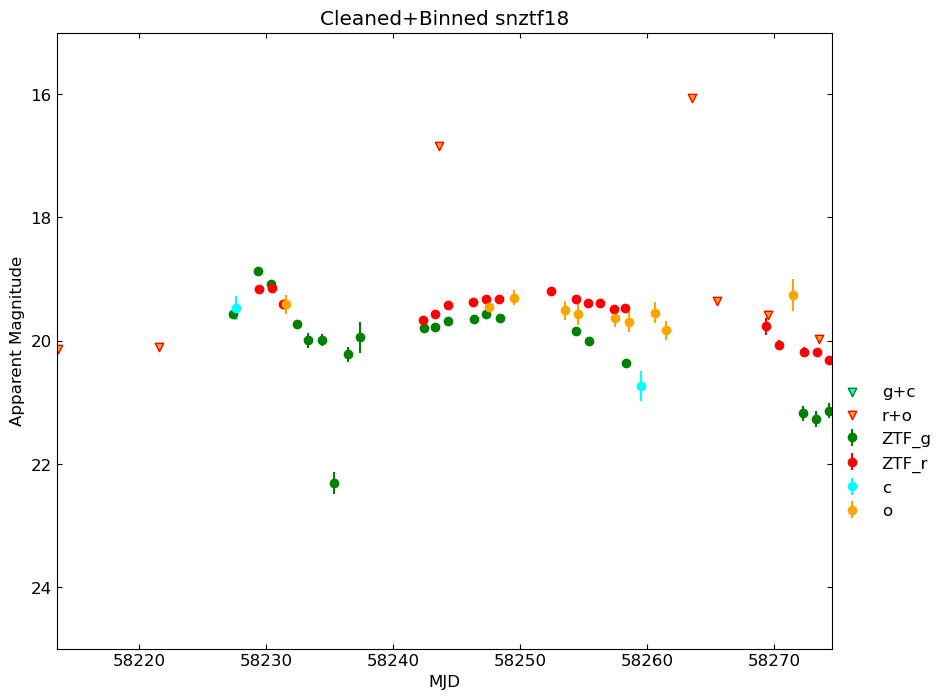

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],


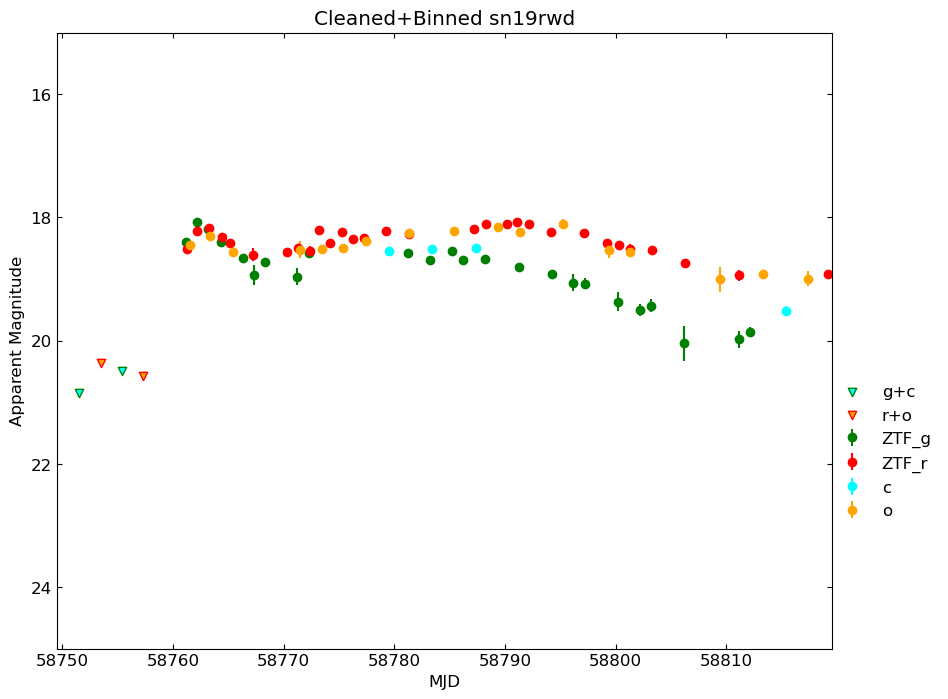

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],


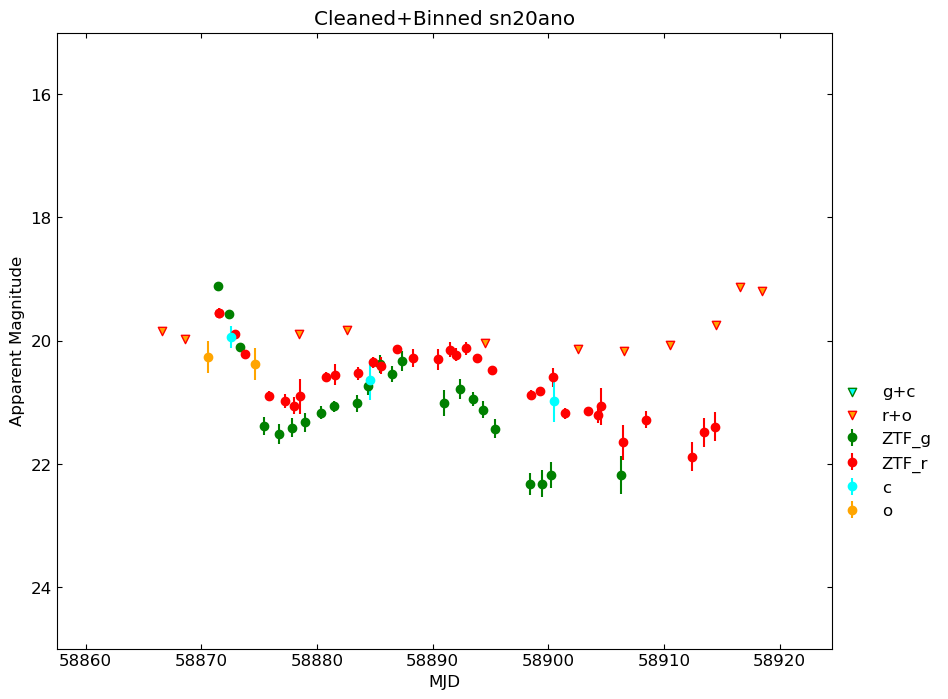

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:34: RuntimeWarning: divide by zero encountered in divide
  avg_fluxes = np.average(df['uJy'][good], weights=1/df['duJy'][good].values**2)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:35: RuntimeWarning: divide by zero encountered in long_scalars
  avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df['duJy'][good].values]))
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:44: RuntimeWarning: divide by zero encountered in log10
  avg_mag = -2.5*np.log10(snu * avg_flux_errs) + 23.9
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:34: RuntimeWarning: divide by zero encountered in divide
  avg_fluxes = np.average(df['uJy'][good], weights=1/df['du

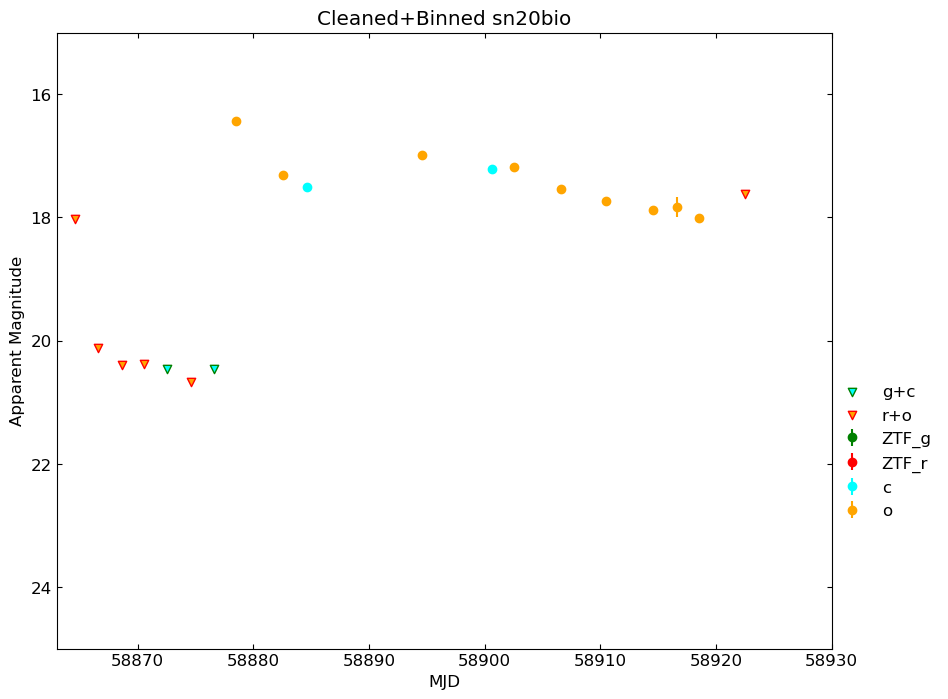

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:34: RuntimeWarning: divide by zero encountered in divide
  avg_fluxes = np.average(df['uJy'][good], weights=1/df['duJy'][good].values**2)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:35: RuntimeWarning: divide by zero encountered in long_scalars
  avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df['duJy'][good].values]))
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:44: RuntimeWarning: divide by zero encountered in log10
  avg_mag = -2.5*np.log10(snu * avg_flux_errs) + 23.9
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

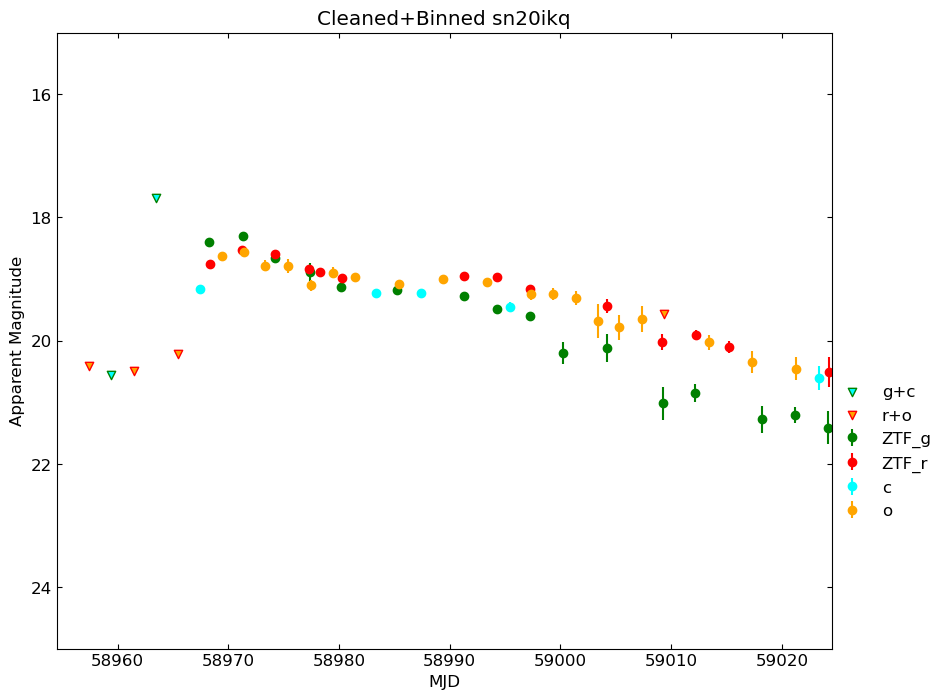

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:34: RuntimeWarning: divide by zero encountered in divide
  avg_fluxes = np.average(df['uJy'][good], weights=1/df['duJy'][good].values**2)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:35: RuntimeWarning: divide by zero encountered in long_scalars
  avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df['duJy'][good].values]))
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:44: RuntimeWarning: divide by zero encountered in log10
  avg_mag = -2.5*np.log10(snu * avg_flux_errs) + 23.9
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

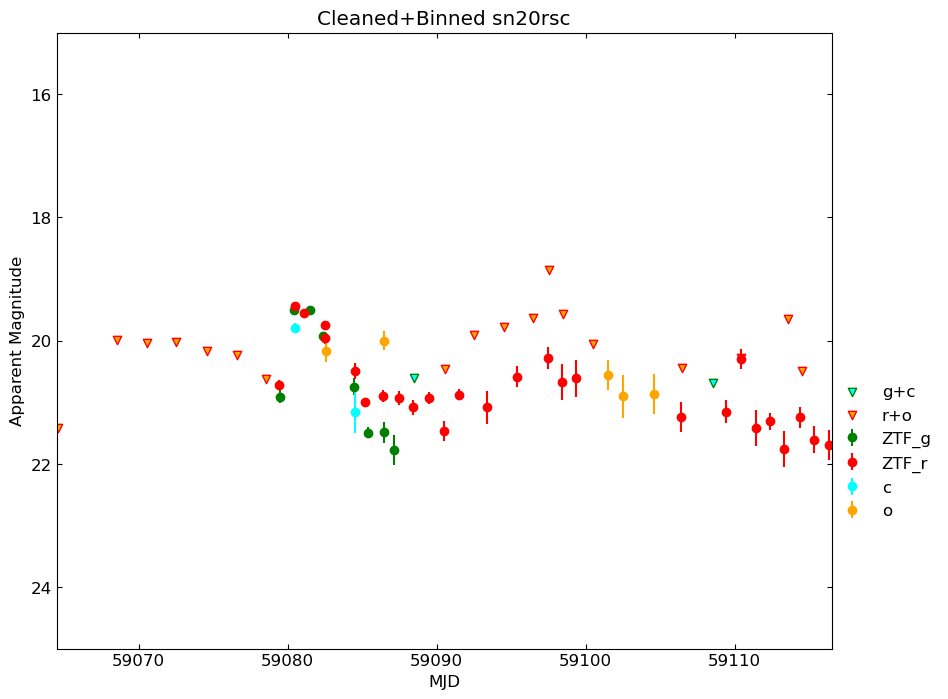

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],


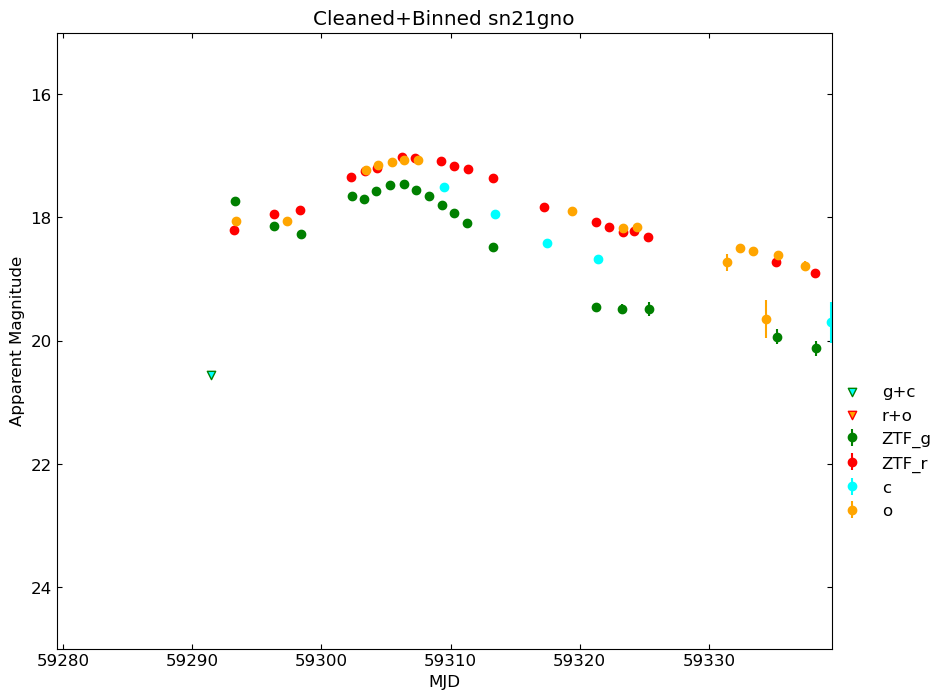

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],


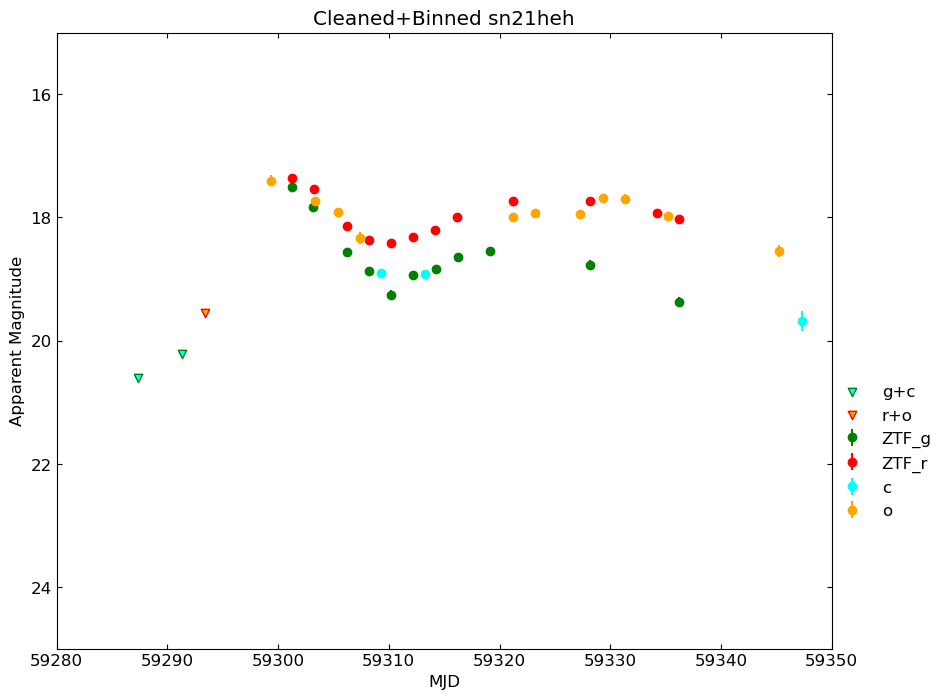

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],


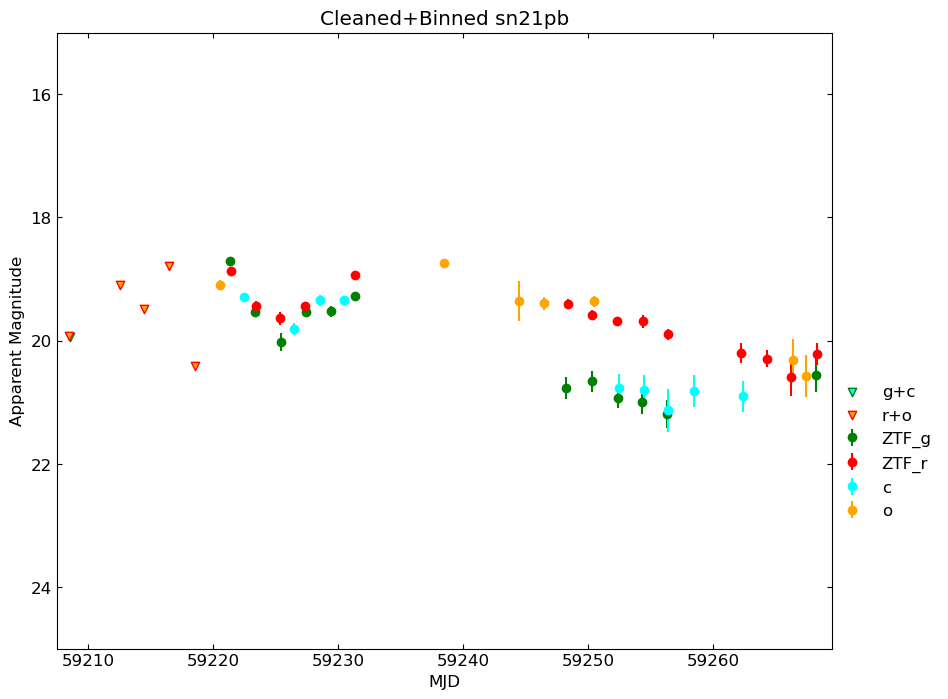

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:34: RuntimeWarning: divide by zero encountered in divide
  avg_fluxes = np.average(df['uJy'][good], weights=1/df['duJy'][good].values**2)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:35: RuntimeWarning: divide by zero encountered in long_scalars
  avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df['duJy'][good].values]))
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:44: RuntimeWarning: divide by zero encountered in log10
  avg_mag = -2.5*np.log10(snu * avg_flux_errs) + 23.9
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

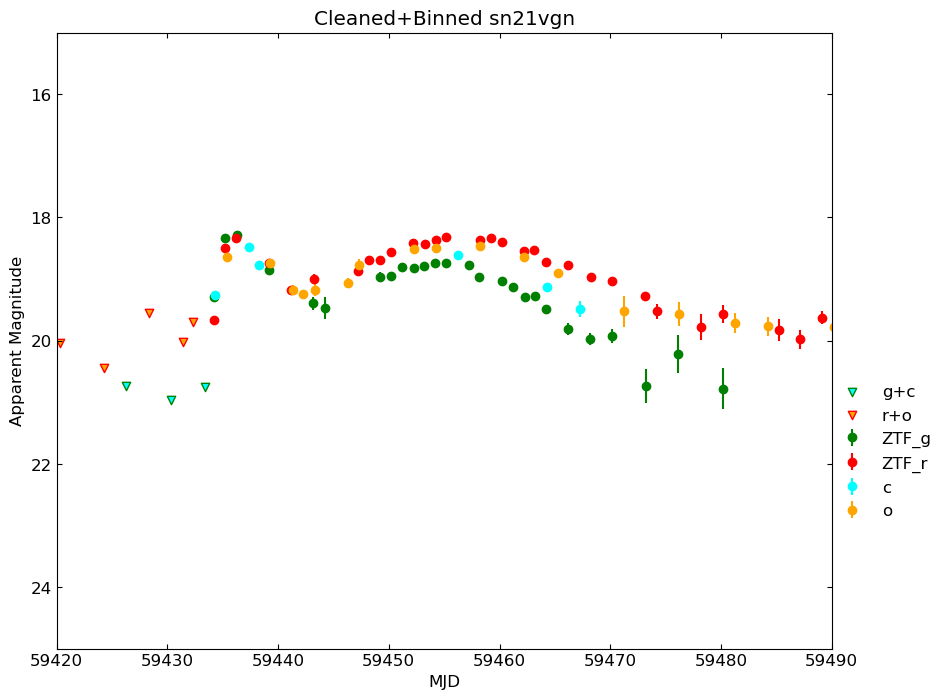

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],


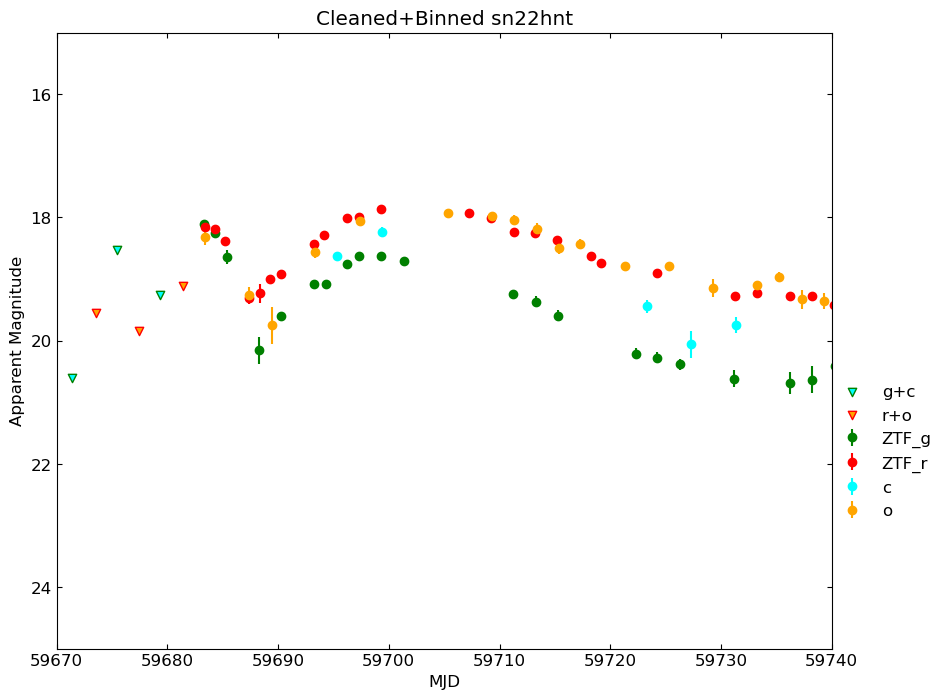

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],


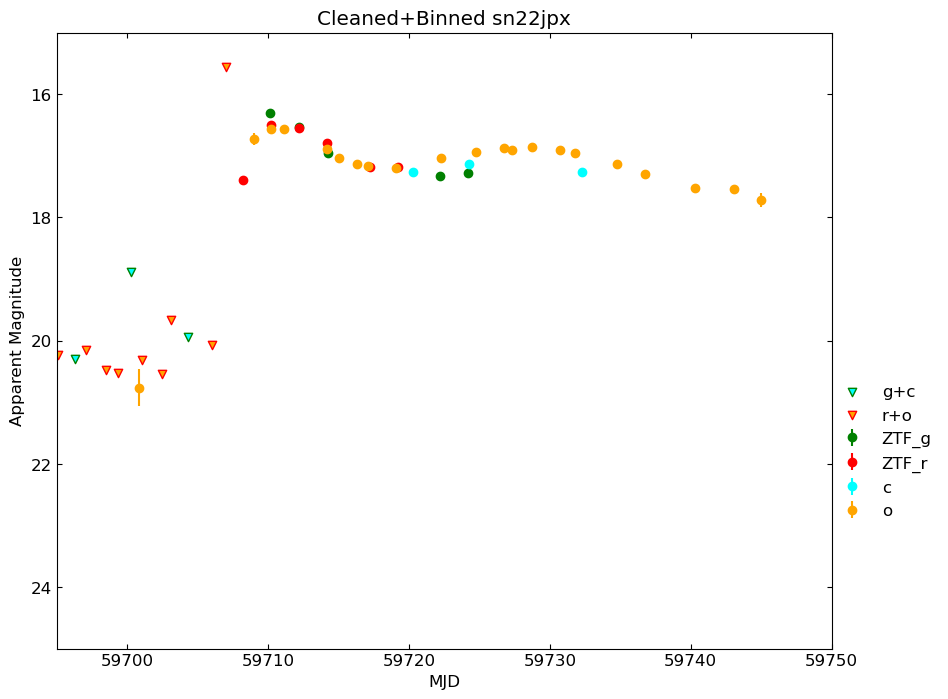

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:34: RuntimeWarning: divide by zero encountered in divide
  avg_fluxes = np.average(df['uJy'][good], weights=1/df['duJy'][good].values**2)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:35: RuntimeWarning: divide by zero encountered in long_scalars
  avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df['duJy'][good].values]))
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/225737820.py:44: RuntimeWarning: divide by zero encountered in log10
  avg_mag = -2.5*np.log10(snu * avg_flux_errs) + 23.9
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_60133/519983733.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

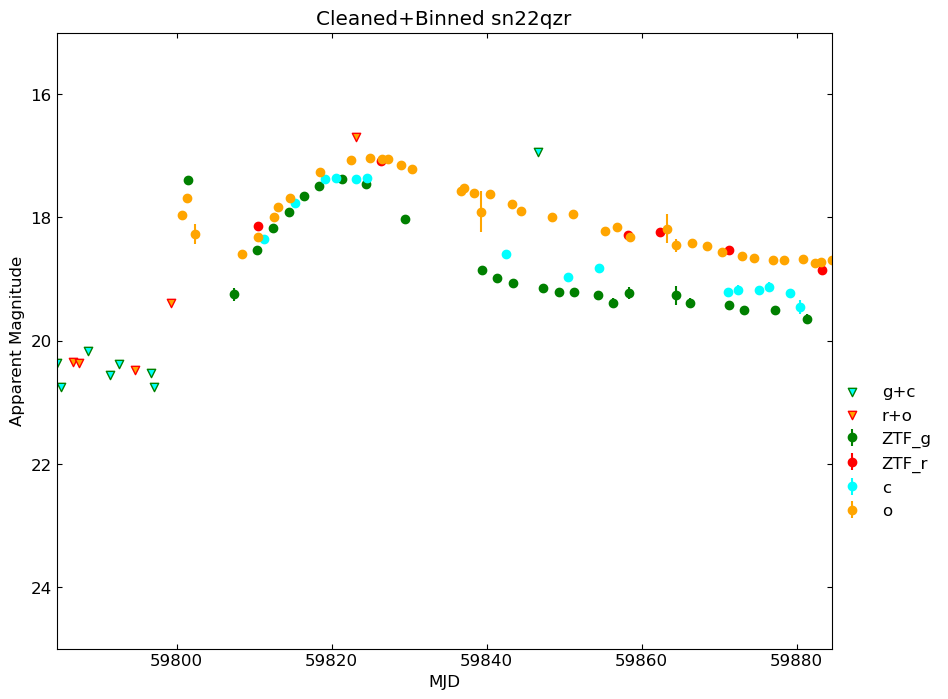

In [51]:
%matplotlib inline
cleaning_routine('snztf18',
                 '../../data/forced_phot_data/ZTF18aalrxas_fp_lc.txt',
                 '../../data/forced_phot_data/snztf18_atlas.txt',
                 xlims_jd_dict['snztf18'][0],
                 xlims_jd_dict['snztf18'][1],
                 plot=True)
cleaning_routine('sn19rwd',
                 '../../data/forced_phot_data/19rwd_fp_lc.txt',
                 '../../data/forced_phot_data/sn19rwd_atlas.txt',
                 xlims_jd_dict['sn19rwd'][0],
                 xlims_jd_dict['sn19rwd'][1],
                 plot=True)
cleaning_routine('sn20ano',
                 '../../data/forced_phot_data/20ano_fp_lc.txt',
                 '../../data/forced_phot_data/sn20ano_atlas.txt',
                 xlims_jd_dict['sn20ano'][0],
                 xlims_jd_dict['sn20ano'][1],
                 plot=True,
                 save=False)
cleaning_routine('sn20bio',
                 '../../data/forced_phot_data/20bio_fp_lc.txt',
                 '../../data/forced_phot_data/sn20bio_atlas.txt',
                 xlims_jd_dict['sn20bio'][0],
                 xlims_jd_dict['sn20bio'][1],
                 plot=True)
cleaning_routine('sn20ikq',
                 '../../data/forced_phot_data/20ikq_fp_lc.txt',
                 '../../data/forced_phot_data/sn20ikq_atlas.txt',
                 xlims_jd_dict['sn20ikq'][0],
                 xlims_jd_dict['sn20ikq'][1],
                 plot=True)
cleaning_routine('sn20rsc',
                 '../../data/forced_phot_data/20rsc_fp_lc.txt',
                 '../../data/forced_phot_data/sn20rsc_atlas.txt',
                 xlims_jd_dict['sn20rsc'][0],
                 xlims_jd_dict['sn20rsc'][1],
                 plot=True)
cleaning_routine('sn21gno',
                 '../../data/forced_phot_data/21gno_fp_lc.txt',
                 '../../data/forced_phot_data/sn21gno_atlas.txt',
                 xlims_jd_dict['sn21gno'][0],
                 xlims_jd_dict['sn21gno'][1],
                 plot=True)
cleaning_routine('sn21heh',
                 '../../data/forced_phot_data/21heh_fp_lc.txt',
                 '../../data/forced_phot_data/sn21heh_atlas.txt',
                 xlims_jd_dict['sn21heh'][0],
                 xlims_jd_dict['sn21heh'][1],
                 plot=True)
cleaning_routine('sn21pb',
                 '../../data/forced_phot_data/21pb_fp_lc.txt',
                 '../../data/forced_phot_data/sn2021pb_atlas.txt',
                 xlims_jd_dict['sn21pb'][0],
                 xlims_jd_dict['sn21pb'][1],
                 plot=True)
cleaning_routine('sn21vgn',
                 '../../data/forced_phot_data/21vgn_fp_lc.txt',
                 '../../data/forced_phot_data/sn21vgn_atlas.txt',
                 xlims_jd_dict['sn21vgn'][0],
                 xlims_jd_dict['sn21vgn'][1],
                 plot=True)
cleaning_routine('sn22hnt',
                 '../../data/forced_phot_data/22hnt_fp_lc.txt',
                 '../../data/forced_phot_data/sn22hnt_atlas.txt',
                 xlims_jd_dict['sn22hnt'][0],
                 xlims_jd_dict['sn22hnt'][1],
                 plot=True)
cleaning_routine('sn22jpx',
                 '../../data/forced_phot_data/22jpx_fp_lc.txt',
                 '../../data/forced_phot_data/sn22jpx_atlas.txt',
                 xlims_jd_dict['sn22jpx'][0],
                 xlims_jd_dict['sn22jpx'][1],
                 plot=True)
cleaning_routine('sn22qzr',
                 '../../data/forced_phot_data/22qzr_fp_lc.txt',
                 '../../data/forced_phot_data/sn22qzr_atlas.txt',
                 xlims_jd_dict['sn22qzr'][0],
                 xlims_jd_dict['sn22qzr'][1],
                 plot=True)